# Ensemble Learning


In broad terms, ensemble methods combine multiple individual models into an ensemble such that the ensemble has a better performance than an individual model on average.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [2]:
PATH_CLASSIFICATION = '../data/iris.csv'
PATH_REGRESSION     = '../data/rent.csv'

In [3]:
label_mapping = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}

data_classification = pd.read_csv(filepath_or_buffer = PATH_CLASSIFICATION)
data_classification['Species'] = data_classification['Species'].map(label_mapping)
data_classification = data_classification.drop('Id', axis = 1)
data_classification.head(n = 3)

,SepalLength[cm],SepalWidth[cm],PetalLength[cm],PetalWidth[cm],Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0


In [4]:
data_regression = pd.read_csv(filepath_or_buffer = PATH_REGRESSION, names = ['Bedrooms', 'Bathrooms', 'Latitude', 'Longitude', 'Price'], skiprows = 1)
data_regression.head(n = 3)

,Bedrooms,Bathrooms,Latitude,Longitude,Price
0,1,1.0,40.7108,-73.9539,2400
1,2,1.0,40.7513,-73.9722,3800
2,2,1.0,40.7575,-73.9625,3495


In [5]:
X_class_train, X_class_valid, y_class_train, y_class_valid = train_test_split(data_classification.drop('Species', axis = 1).values, data_classification['Species'].values, test_size = 0.25, random_state = 123, stratify = data_classification['Species'].values)

print(f'Training set shape: {X_class_train.shape}, Classes shape: {y_class_train.shape}')
print(f'Validation set shape: {X_class_valid.shape}, Classes shape: {y_class_valid.shape}')
print(f'Train set class distribution: {np.bincount(y_class_train)}. Validation set class distribution: {np.bincount(y_class_valid)}')

Training set shape: (112, 4), Classes shape: (112,)
Validation set shape: (38, 4), Classes shape: (38,)
Train set class distribution: [38 37 37]. Validation set class distribution: [12 13 13]


In [6]:
X_regression_train, X_regression_valid, y_regression_train, y_regression_valid = train_test_split(data_regression.drop('Price', axis = 1).values, data_regression['Price'].values, test_size = 0.25, random_state = 123)

print(f'Training set shape: {X_regression_train.shape}, Classes shape: {y_regression_train.shape}')
print(f'Validation set shape: {X_regression_valid.shape}, Classes shape: {y_regression_valid.shape}')

Training set shape: (36225, 4), Classes shape: (36225,)
Validation set shape: (12075, 4), Classes shape: (12075,)


## A. Majority and Soft Majority Voting

Let us assume that we have $n$ different models $\{h_1, h_2, \dots, h_n\}$ where $h_i(\vec{x}) = \hat{y_i}$.
In the case of classifiers, the final ensemble prediction is: 

$$\hat{y}_{pred} = mode\{h_1(\vec{x}), h_2(\vec{x}), ... h_n(\vec{x})\}$$

In the case of regressors, the final ensemble prediction is: 

$$\hat{y}_{pred} = \frac{1}{n}\sum_{i = 1}^{n} h_i(\vec{x})$$


In soft majority voting scheme, the class prediction is calculated as:

$$ \hat{y}_{pred} = \arg\!\max_j \sum_{i = 1}^{n} w_ip_{i,j} $$

where $p_{i,j}$ is the predicted class membership probability for class label $j$ by the $i$th classifier.
Here $w_i$ is an optional weighting parameter (possibly explaining the model reliability).
To illustrate this, let us assume we have a binary classification problem with class labels
$j \in {0, 1}$ and an ensemble of three classifiers $h_i(i \in {1, 2, 3})$:

$$ h_1(x) = [0.9, 0.1], h_2(x) = [0.8, 0.2], h_3(x) = [0.4, 0.6] $$

We can then calculate the individual class membership probabilities as follows:

$$ p(j = 0 \mid x) = 0.2*0.9 + 0.2*0.8 + 0.6*0.4 = 0.58 $$

$$ p(j = 1 \mid x) = 0.2*0.1+0.2*0.2+0.6*0.6 = 0.42 $$

The predicted class label is then:

$$ \hat{y}_{pred} = \arg\!\max_j \{p(j = 0 \mid x), p(j = 1 \mid x)\} = 0 $$

In the case of regressors, the final ensemble prediction is:

$$ \hat{y}_{pred} =  \frac{1}{\sum_{i = 1}^{n}w_i}\sum_{i = 1}^{n} w_ih_i({\vec{x})} $$

In [7]:
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import VotingClassifier

In [8]:
# classifier models
classifier1 = DecisionTreeClassifier(random_state = 1, max_depth = None)
classifier2 = DecisionTreeClassifier(random_state = 1, max_depth = 1)
classifier3 = DecisionTreeClassifier(random_state = 1, max_depth = 2)

# ensemble of classifiers
ensemble_hard = VotingClassifier(estimators = [('classifier1', classifier1), ('classifier2', classifier2), ('classifier3', classifier3)], weights = [1, 1, 1], voting = 'hard')
ensemble_soft = VotingClassifier(estimators = [('classifier1', classifier1), ('classifier2', classifier2), ('classifier3', classifier3)], weights = [1, 1, 1], voting = 'soft')

classifier1.fit(X = X_class_train, y = y_class_train);
classifier2.fit(X = X_class_train, y = y_class_train);
classifier3.fit(X = X_class_train, y = y_class_train);
ensemble_hard.fit(X = X_class_train, y = y_class_train);
ensemble_soft.fit(X = X_class_train, y = y_class_train);

In [9]:
print(f'Feature vector: {X_class_valid[31]}, Class: {y_class_valid[31]}')
print(f'Classifier 1 = {classifier1.predict([X_class_valid[31]])}, Classifier 2 = {classifier2.predict([X_class_valid[31]])}, Classifier 3 = {classifier3.predict([X_class_valid[31]])}')
print(f'Ensemble (hard) = {ensemble_hard.predict([X_class_valid[31]])}')

print(f'Accuracy -- classifier 1 = {classifier1.score(X_class_valid, y_class_valid)}')
print(f'Accuracy -- classifier 2 = {classifier2.score(X_class_valid, y_class_valid)}')
print(f'Accuracy -- classifier 3 = {classifier3.score(X_class_valid, y_class_valid)}')
print(f'Accuracy -- ensemble (hard) = {ensemble_hard.score(X_class_valid, y_class_valid)}')

Feature vector: [5.8 2.7 5.1 1.9], Class: 2
Classifier 1 = [2], Classifier 2 = [1], Classifier 3 = [2]
Ensemble (hard) = [2]
Accuracy -- classifier 1 = 0.9736842105263158
Accuracy -- classifier 2 = 0.6578947368421053
Accuracy -- classifier 3 = 0.9473684210526315
Accuracy -- ensemble (hard) = 0.9736842105263158


In [10]:
print(f'Feature vector: {X_class_valid[31]}, Class: {y_class_valid[31]}')
print(f'Classifier 1 = {classifier1.predict_proba([X_class_valid[31]])[0]}, Classifier 2 = {classifier2.predict_proba([X_class_valid[31]])[0]}, Classifier 3 = {classifier3.predict_proba([X_class_valid[31]])[0]}')
print(f'Ensemble (soft) = {ensemble_soft.predict_proba([X_class_valid[31]])[0]}')

print(f'Accuracy -- classifier 1 = {classifier1.score(X_class_valid, y_class_valid)}')
print(f'Accuracy -- classifier 2 = {classifier2.score(X_class_valid, y_class_valid)}')
print(f'Accuracy -- classifier 3 = {classifier3.score(X_class_valid, y_class_valid)}')
print(f'Accuracy -- ensemble (hard) = {ensemble_soft.score(X_class_valid, y_class_valid)}')

Feature vector: [5.8 2.7 5.1 1.9], Class: 2
Classifier 1 = [0. 0. 1.], Classifier 2 = [0.  0.5 0.5], Classifier 3 = [0.  0.1 0.9]
Ensemble (soft) = [0.  0.2 0.8]
Accuracy -- classifier 1 = 0.9736842105263158
Accuracy -- classifier 2 = 0.6578947368421053
Accuracy -- classifier 3 = 0.9473684210526315
Accuracy -- ensemble (hard) = 0.9736842105263158


In [11]:
# regression models
regressor1 = DecisionTreeRegressor(random_state = 1, max_depth = None)
regressor2 = DecisionTreeRegressor(random_state = 1, max_depth = 1)
regressor3 = DecisionTreeRegressor(random_state = 1, max_depth = 2)

# ensemble of regressors
ensemble_equal_weights = VotingRegressor(estimators = [('regressor1', regressor1), ('regressor2', regressor2), ('regressor3', regressor3)], weights = [1, 1, 1])
ensemble_unequal_weights = VotingRegressor(estimators = [('regressor1', regressor1), ('regressor2', regressor2), ('regressor3', regressor3)], weights = [5, 2, 1])

regressor1.fit(X = X_regression_train, y = y_regression_train);
regressor2.fit(X = X_regression_train, y = y_regression_train);
regressor3.fit(X = X_regression_train, y = y_regression_train);
ensemble_equal_weights.fit(X = X_regression_train, y = y_regression_train);
ensemble_unequal_weights.fit(X = X_regression_train, y = y_regression_train);

In [12]:
print(f'Feature vector: {X_regression_valid[0]}, Target: {y_regression_valid[0]}')
print(f'Regressor 1 = {regressor1.predict([X_regression_valid[0]])}, Regressor 2 = {regressor2.predict([X_regression_valid[0]])}, Regressor 3 = {regressor3.predict([X_regression_valid[0]])}')
print(f'Ensemble (equal weights) = {ensemble_equal_weights.predict([X_regression_valid[0]])}')
print(f'Ensemble (unequal weights) = {ensemble_unequal_weights.predict([X_regression_valid[0]])}')

print(f'R^2 score -- regressor 1 = {regressor1.score(X_regression_valid, y_regression_valid)}')
print(f'R^2 score -- regressor 2 = {regressor2.score(X_regression_valid, y_regression_valid)}')
print(f'R^2 score -- regressor 3 = {regressor3.score(X_regression_valid, y_regression_valid)}')
print(f'R^2 score -- ensemble (equal weights) = {ensemble_equal_weights.score(X_regression_valid, y_regression_valid)}')
print(f'R^2 score -- ensemble (unequal weights) = {ensemble_unequal_weights.score(X_regression_valid, y_regression_valid)}')

Feature vector: [  3.       2.      40.7773 -73.9532], Target: 3800
Regressor 1 = [3800.], Regressor 2 = [5315.39510543], Regressor 3 = [5587.29809763]
Ensemble (equal weights) = [4900.89773435]
Ensemble (unequal weights) = [4402.26103856]
R^2 score -- regressor 1 = 0.8169192047486176
R^2 score -- regressor 2 = 0.3951159880255374
R^2 score -- regressor 3 = 0.49252838519484055
R^2 score -- ensemble (equal weights) = 0.6931598270591892
R^2 score -- ensemble (unequal weights) = 0.797543170017368


## B. Bagging

Bagging relies on a concept similar to majority voting but uses the same learning algorithm (typically a decision tree algorithm) to fit models on different subsets of the training data (bootstrap samples).
In a nutshell, a bootstrap sample is a sample of size $n$ drawn with replacement from an original training set $\mathcal{D}$ with $|\mathcal{D}| = n$. 
Consequently, some training examples are duplicated in each bootstrap sample, and some other training examples do not appear in a given bootstrap sample at all (usually, we refer to these examples as "out-of-bag sample".)
In the limit, there are approx. $63.2\%$ unique examples in a given bootstrap sample.
Consequently, $37.2\%$ examples from the original training set won’t appear in a given bootstrap sample at all.

In [13]:
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import BaggingClassifier

In [14]:
classification_tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = None, random_state = 1)
bagging_classifier = BaggingClassifier(base_estimator = classification_tree, n_estimators = 100, bootstrap_features = False, oob_score = True, n_jobs = -1, random_state = 123)

bagging_classifier.fit(X = X_class_train, y = y_class_train)

print(f'OOB Accuracy: {bagging_classifier.oob_score_:.2f}%')
print(f'Validation Accuracy: {bagging_classifier.score(X_class_valid, y_class_valid):.2f}%')

OOB Accuracy: 0.94%
Validation Accuracy: 0.97%


In [15]:
regression_tree = DecisionTreeRegressor(max_depth = None, random_state = 1)
bagging_regressor = BaggingRegressor(base_estimator = regression_tree, n_estimators = 100, bootstrap_features = False, oob_score = True, n_jobs = -1, random_state = 123)

bagging_regressor.fit(X = X_regression_train, y = y_regression_train)

print(f'OOB Score: {bagging_regressor.oob_score_:.2f}%')
print(f'Validation R^2 Score: {bagging_regressor.score(X_regression_valid, y_regression_valid):.2f}%')

OOB Score: 0.86%
Validation R^2 Score: 0.85%


## C. Boosting

There are two broad categories of boosting: adaptive boosting and gradient boosting.
Boosting is an iterative process, where the training set is reweighted, at each iteration, based on mistakes a previous leaner made (i.e., misclassifications); the two approaches, adaptive and gradient boosting, differ mainly regarding how the weights are updated and how the classifiers are combined.

### C.1 Adaptive Boosting - AdaBoost

Intuitively, we can outline the general boosting procedure for AdaBoost as follows:

  - Initialize a weight vector with uniform weights.
  
  - Loop:
  
    - Apply *weak learner* to weighted training examples (instead of original training set, may draw bootstrap samples with weighted probability).
    
    - Increase weight for misclassified examples.
    
  - (Weighted) majority voting on trained classifiers.
  
**Algorithm**:

  1. Initialize $k$: the number of AdaBoost rounds.
  2. Initialize $\mathcal{D}$: the training dataset, $\mathcal{D} = {\{ <\vec{x_1}, y_1>, \dots, <\vec{x_n}, y_n> \}}$
  3. Initialize $w_1(i) = \frac{1}{n}$, for $i = 1, \dots, n$
  4. **loop** $r = 1 \dots k$:
     - $w_r(i) = \frac{w_r(i)}{\sum_{i = 1}^{n} w_r(i)}$ for $i = 1, \dots, n$
     
     - $h_r = FitWeakLearner(\mathcal{D}, \vec{w_r})$ -- [weighted dataset]
     
     - $\mathcal{e}_r = \sum_{i = 1}^{n}w_r(i)*(h_r(i) \neq y_i)$
     
     - **if** $\mathcal{e}_r \gt \frac{1}{2}$ then stop -- [$\frac{1}{1 - c}$ where $c$ is the number of
unique class labels for multiple classes]

     - $\alpha_r = \frac{1}{2}log(\frac{1 - \mathcal{e}_r}{\mathcal{e}_r})$ -- [small if error is large and vice versa, for multiple classes use: $\alpha_r = log(\frac{1 - \mathcal{e}_r}{\mathcal{e}_r}) - log(c - 1)$]
     
     - $w_{r + 1}(i) = w_r(i) \times \begin{cases}
                                        e^{-\alpha_r},& \text{if } h_r(\vec{x_i}) = y_i\\
                                        e^{\alpha_r},& \text{if } h_r(\vec{x_i}) \neq y_i
                                     \end{cases}
       $  
  5. Prediction $\hat{y}_{pred} = \arg\!\max_j \sum_{r = 1}^{k} \alpha_r (h_r(\vec{x}) = j)$

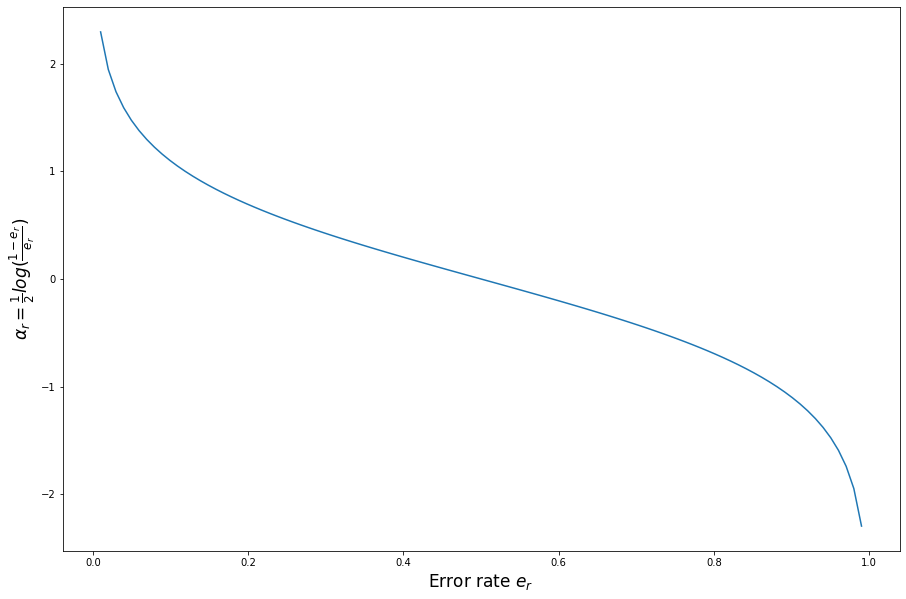

In [16]:
x = np.linspace(start = 0.01, stop = .99, num = 100)
alpha = 1/2*np.log((1 - x) / x)

figure, axes = plt.subplots(figsize = (15, 10))
axes.plot(x, alpha);
axes.set_xlabel('Error rate $e_r$', fontsize = 17);
axes.set_ylabel('$\\alpha_r = \\frac{1}{2}log(\\frac{1 - e_r}{e_r})$', fontsize = 17);

In [17]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier

In [18]:
classification_tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 1, max_depth = 1)
classifier_adaboost = AdaBoostClassifier(base_estimator = classification_tree, n_estimators = 100, algorithm = 'SAMME')

classifier_adaboost.fit(X = X_class_train, y = y_class_train)

print(f'Validation Accuracy: {classifier_adaboost.score(X_class_valid, y_class_valid):.2f}%')

Validation Accuracy: 0.95%


In [19]:
classification_tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 1, max_depth = 1)
classifier_boost = AdaBoostClassifier(base_estimator = classification_tree, n_estimators = 3, algorithm = 'SAMME')

classifier_boost.fit(X = X_class_train, y = y_class_train)

print(f'Feature vector: {X_class_valid[31]}, Target: {y_class_valid[31]}')

for index, estimator in enumerate(classifier_boost.estimators_):
    print(f'Estimator {index}: {estimator.predict_proba([X_class_valid[31]])[0]}')
    
print(f'AdaBoost weights: {classifier_boost.estimator_weights_}')
print(f'AdaBoost estimator errors: {classifier_boost.estimator_errors_}')
print(f'AdaBoost probabilities: {classifier_boost.predict_proba([X_class_valid[31]])[0]}')
print(f'AdaBoost predictions: {classifier_boost.predict([X_class_valid[31]])}')

Feature vector: [5.8 2.7 5.1 1.9], Target: 2
Estimator 0: [0.  0.5 0.5]
Estimator 1: [0.         0.02667628 0.97332372]
Estimator 2: [0.        0.0512008 0.9487992]
AdaBoost weights: [1.39971738 2.19289953 2.73886883]
AdaBoost estimator errors: [0.33035714 0.18246246 0.1144854 ]
AdaBoost probabilities: [0.27831386 0.3108423  0.41084385]
AdaBoost predictions: [2]


In [20]:
regression_tree = DecisionTreeRegressor(random_state = 1, max_depth = 2)
regression_adaboost = AdaBoostRegressor(base_estimator = regression_tree, n_estimators = 10, random_state = 1)

regression_adaboost.fit(X = X_regression_train, y = y_regression_train)

print(f'Validation R^2 Score: {regression_adaboost.score(X_regression_valid, y_regression_valid):.2f}')

Validation R^2 Score: 0.50
